In [51]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

from tenpy.networks.mpo import MPO
from tenpy.networks.mps import MPS
from tenpy.networks.site import SpinHalfSite
from tenpy.models.model import MPOModel
from tenpy.models.lattice import Chain
from tenpy.algorithms import dmrg

In [52]:
def get_Ising_MPO(L, J1, g):
    # Define the sites and the lattice, which in this case is a simple uniform chain
    # of spin 1/2 sites
    site = SpinHalfSite(conserve=None)
    lat = Chain(L, site, bc_MPS="finite", bc="open")

    # Define the operators that appear in the Hamiltonian.
    sx, sz, Id = site.Sigmax, site.Sigmaz, site.Id

    # The grid (list of lists) that defines the MPO
    grid = [
        [Id, J1 * sz, g * sx],
        [None, None, sz],
        [None, None, Id],
    ]
    grids = [grid] * L

    # Generate the MPO Hamiltonian from the grid.
    H = MPO.from_grids(lat.mps_sites(), grids, bc="finite", IdL=0, IdR=-1)
    return H, lat

In [53]:
def run_dmrg(model_pams):
    H, lat = get_Ising_MPO(model_pams["L"], model_pams["J1"], model_pams["g"])

    # Get the model from the MPO Hamiltonian and lattice
    model = MPOModel(lat, H)

    # Initialize the wavefunction from the model, using spin up for all lattice sites
    psi = MPS.from_product_state(model.lat.mps_sites(), ["up"] * model_pams["L"], "finite")

    # Define the parameters to run the DMRG optimization algorithm
    dmrg_pams = {
        "mixer": True,
        "chi_list": {0: 100},
        "trunc_params": {"svd_min": 1.0e-10},
        # "verbose": 1,
    }

    # Run the DMRG algorithm
    results = dmrg.run(psi, model, dmrg_pams)
    mag_x = np.sum(psi.expectation_value("Sigmax"))
    mag_z = np.sum(psi.expectation_value("Sigmaz"))

    return results["E"], mag_x, mag_z

In [54]:
def Ising_diag_4sites(J1, g):
    sx, sz, iD = (
        np.matrix([[0, 1], [1, 0]]),
        np.matrix([[1, 0], [0, -1]]),
        np.identity(2),
    )

    H1 = (
        np.kron(sz, np.kron(sz, np.kron(iD, iD)))
        + np.kron(iD, np.kron(sz, np.kron(sz, iD)))
        + np.kron(iD, np.kron(iD, np.kron(sz, sz)))
    )

    H2 = (
        np.kron(sx, np.kron(iD, np.kron(iD, iD)))
        + np.kron(iD, np.kron(sx, np.kron(iD, iD)))
        + np.kron(iD, np.kron(iD, np.kron(sx, iD)))
        + np.kron(iD, np.kron(iD, np.kron(iD, sx)))
    )

    w, v = LA.eig(J1 * H1 + g * H2)

    return min(w)

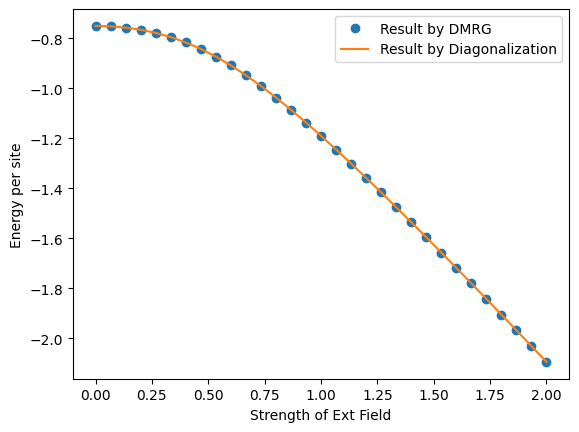

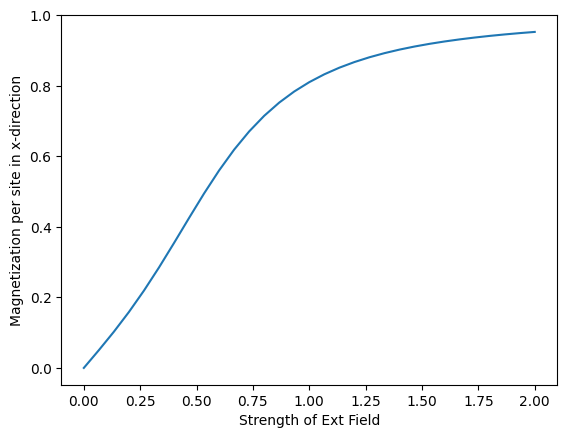

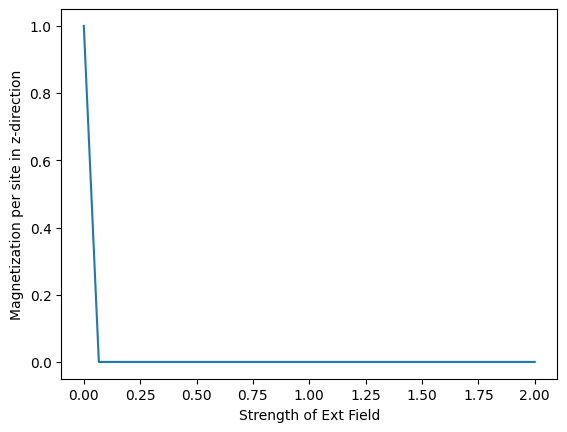

In [55]:
if __name__ == "__main__":

    g_range = np.linspace(0, 2.0, 31)
    ground_energy_range = []
    ground_energy_range_manual = []
    magx = []
    magz = []
    for g in g_range:
        # set the model parameters
        L, J1 = 4, -1.0
        model_pams = {"L": L, "J1": J1, "g": g}

        # run the DMRG optimization algorithm
        ground_energy, mag_x, mag_z = run_dmrg(model_pams)
        # Save the results
        ground_energy_range.append(ground_energy/L)
        magx.append(mag_x/L)
        magz.append(mag_z/L)

        # Find the ground state energy to compare to the DMRG result
        ground_energy_manual = Ising_diag_4sites(J1, g)
        ground_energy_range_manual.append(ground_energy_manual/L)


    plt.plot(g_range, ground_energy_range, "o", label="Result by DMRG")
    plt.plot(g_range, ground_energy_range_manual, label="Result by Diagonalization")
    plt.ylabel("Energy per site")
    plt.xlabel("Strength of Ext Field")
    plt.legend(loc="upper right")
    plt.show()

    plt.plot(g_range, np.abs(magx))
    plt.ylabel("Magnetization per site in x-direction")
    plt.xlabel("Strength of Ext Field")
    plt.show()

    plt.plot(g_range, magz)
    plt.ylabel("Magnetization per site in z-direction")
    plt.xlabel("Strength of Ext Field")
    plt.show()